
###  Dog Breed Classification Model

The goal is to classify images of dogs into one of several predefined breeds (e.g., Labrador, Poodle, Bulldog, etc.).

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf

from tensorflow import keras
from keras import layers
from functools import partial

import warnings
warnings.filterwarnings('ignore')
AUTO = tf.data.experimental.AUTOTUNE

Extracting the dataset from zip

In [5]:
from zipfile import ZipFile
data_path = 'dog-breed-identification.zip'


#Extract dataset from zip file 
with ZipFile(data_path, 'r') as zip:
    zip.extractall()
    print('The data set has been extracted.')

The data set has been extracted.


In [6]:
#Using pandas to load dataset (csv format)
df = pd.read_csv('labels.csv')
df.head() #preview of dataset

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
#Basic Exploratory Data Analysis
breed = df['breed'].nunique()
print(f'There are {breed} breeds in the dataset')

There are 120 breeds in the dataset


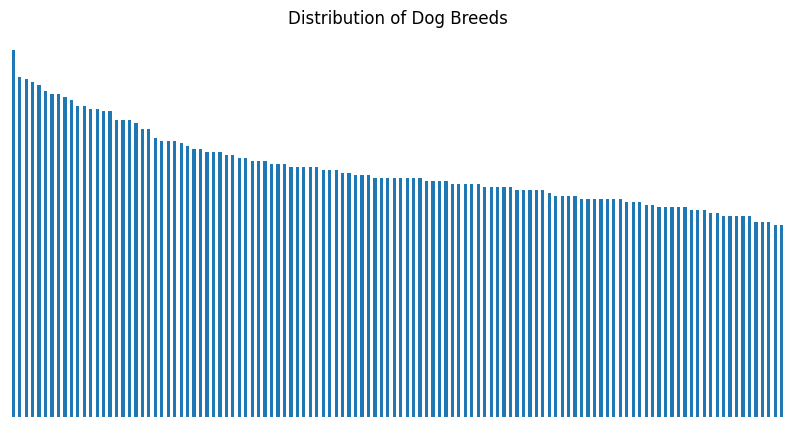

In [9]:
plt.figure(figsize=(10, 5))
df['breed'].value_counts().plot.bar()
plt.axis('off')
plt.title('Distribution of Dog Breeds')
plt.show()

In [10]:
#Training set of data

df['labels.csv'] = 'train/' + df['id'] + '.jpg'
df.head()

,id,breed,labels.csv
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


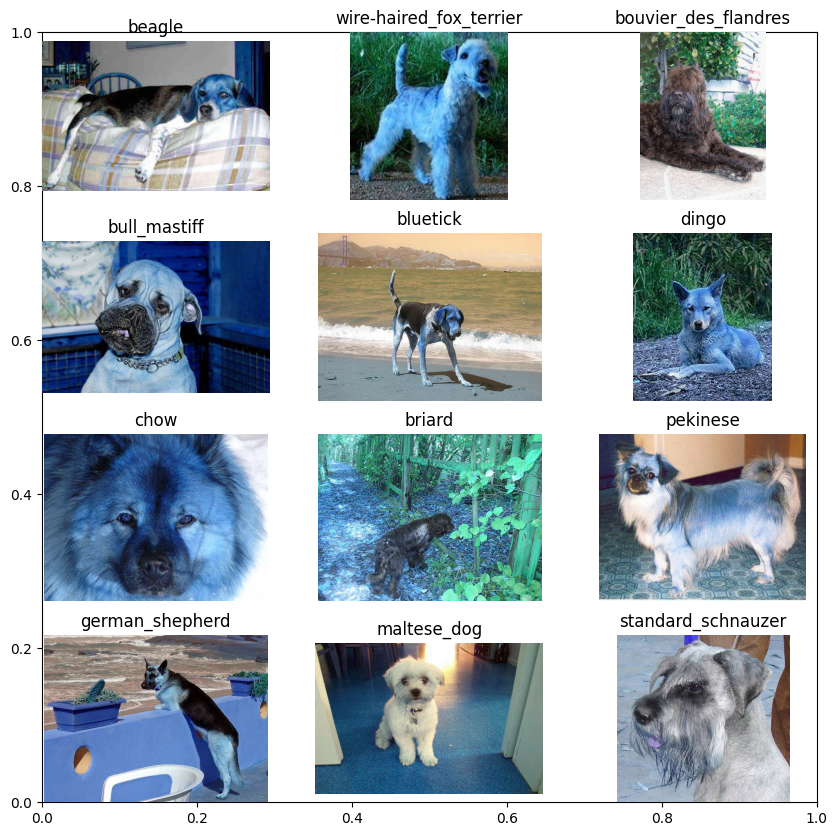

In [11]:
plt.subplots(figsize=(10, 10))
for i in range(12):
    plt.subplot(4, 3, i+1)

    # Selecting a random image
    # index from the dataframe.
    k = np.random.randint(0, len(df))
    img = cv2.imread(df.loc[k, 'labels.csv'])
    plt.imshow(img)
    plt.title(df.loc[k, 'breed'])
    plt.axis('off')
plt.show()

In [12]:
le = LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])
df.head()

,id,breed,labels.csv
0,000bec180eb18c7604dcecc8fe0dba07,19,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,37,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,85,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,15,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,49,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [ ]:
#Data Preparation
features = df['labels.csv']
target = df['breed']

#Split into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)

X_train.shape, X_val.shape

#number of rows and columns in the dataset 

((8688,), (1534,))

In [14]:
#Implementing augmentation
import albumentations as A

transforms_train = A.Compose([
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.7),
    A.CoarseDropout(p=0.5),
    A.RandomGamma(p=0.5),
    A.RandomBrightnessContrast(p=1)
]) 

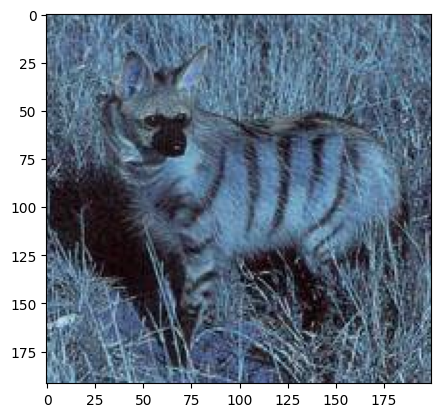

In [15]:
img = cv2.imread('train/00792e341f3c6eb33663e415d0715370.jpg')
plt.imshow(img)
plt.show()

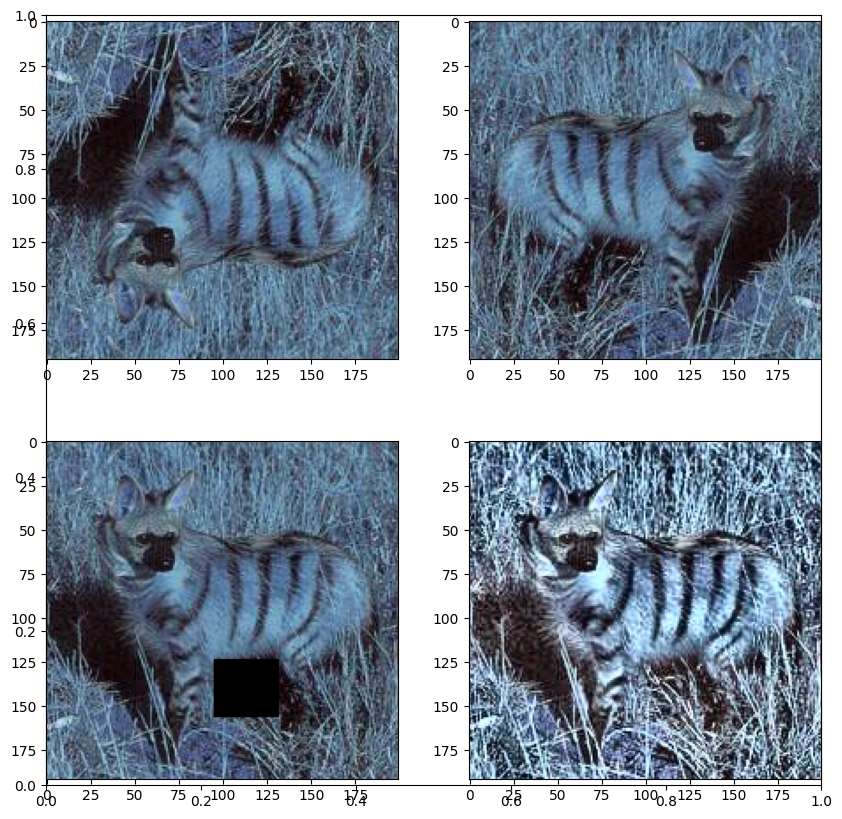

In [17]:
# Apply several augmentations, such as VerticalFlip, HorizontalFlip, CoarseDropout, and CLAHE, and visualize the results
augments = [A.VerticalFlip(p=1), A.HorizontalFlip(p=1),
            A.CoarseDropout(p=1), A.CLAHE(p=1)]

plt.subplots(figsize=(10, 10))
for i, aug in enumerate(augments):
    plt.subplot(2, 2, i+1)
    aug_img = aug(image=img)['image']
    plt.imshow(aug_img)
plt.show()

In [20]:
# Building the Input Pipeline for the data

# Functions to handle image loading, augmentation, and normalization
def aug_fn(img):
    aug_data = transforms_train(image=img)
    aug_img = aug_data['image']

    return aug_img


@tf.function
def process_data(img, label):
    aug_img = tf.numpy_function(aug_fn,
                                [img],
                                Tout=tf.float32)

    return img, label


def decode_image(filepath, label=None):

    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0

    if label == None:
        return img

    return img, tf.one_hot(indices=label,
                           depth=120,
                           dtype=tf.float32)

In [21]:
# Implementing our training data input pipeline and the validation data pipeline.
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(partial(process_data), num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

In [22]:
for img, label in train_ds.take(1):
  print(img.shape, label.shape)

(32, 128, 128, 3) (32, 120)


2025-05-05 20:07:40.834999: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
# Model Building Using Transfer Learning
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape=(128, 128, 3),
    weights='imagenet',
    include_top=False
)

In [24]:
#InceptionV3 is a deep network with many layers, which makes it effective in 
#learning complex features from images. Let’s check the number of layers 
#in this pre-trained model.

len(pre_trained_model.layers)

311

In [25]:
for layer in pre_trained_model.layers: 
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7') 
# Access the output shape from the output tensor of the layer
print('last layer output shape: ', last_layer.output.shape) 
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 768)


In [26]:
# Model Architecture
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(120, activation='softmax')(x)

#Nueral Networks 

model = keras.Model(pre_trained_model.input, output)

# Model Compilation
model.compile(
	optimizer='adam',
	loss=keras.losses.CategoricalCrossentropy(from_logits=True),
	metrics=[tf.keras.metrics.AUC()]
)

In [27]:
#Now testing if our model worked since we ran it last cell
#Validation 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_auc') is not None and logs.get('val_auc') > 0.99:
			print('\n Validation accuracy has reached upto 90% so, stopping further training.')
			self.model.stop_training = True

es = EarlyStopping(patience=3,
                monitor='val_auc',
                restore_best_weights=True,
                mode='max')

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)

In [28]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    verbose=1,
                    callbacks=[es, lr, myCallback()])
#Training has started 

Epoch 1/50


I0000 00:00:1746456110.120538 7747991 service.cc:152] XLA service 0x31d109fc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746456110.120666 7747991 service.cc:160]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1746456110.286621 7747991 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


272/272 ━━━━━━━━━━━━━━━━━━━━ 69s 242ms/step - auc: 0.7194 - loss: 4.3401 - val_auc: 0.9276 - val_loss: 2.6407 - learning_rate: 0.0010
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 63s 231ms/step - auc: 0.9614 - loss: 2.2297 - val_auc: 0.9336 - val_loss: 2.3645 - learning_rate: 0.0010
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 65s 237ms/step - auc: 0.9914 - loss: 1.2155 - val_auc: 0.9273 - val_loss: 2.4108 - learning_rate: 0.0010
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - auc: 0.9993 - loss: 0.5002
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
272/272 ━━━━━━━━━━━━━━━━━━━━ 64s 237ms/step - auc: 0.9993 - loss: 0.4999 - val_auc: 0.9183 - val_loss: 2.4756 - learning_rate: 0.0010
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 71s 260ms/step - auc: 0.9999 - loss: 0.1759 - val_auc: 0.9269 - val_loss: 2.3023 - learning_rate: 5.0000e-04


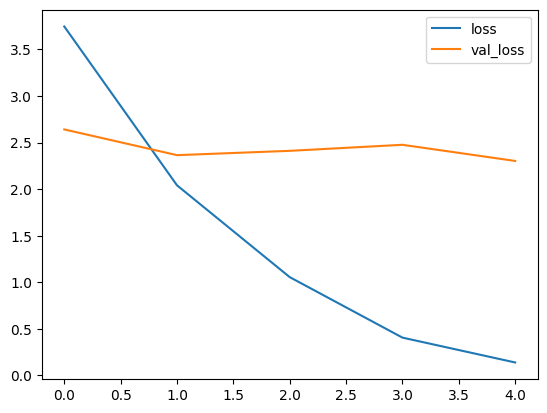

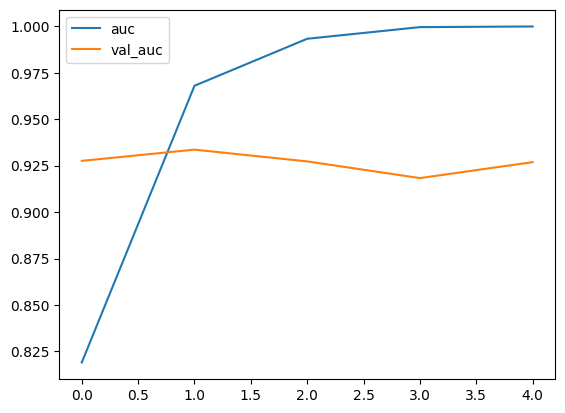

In [29]:
#with each epoch loss reduce making model more accurate
history_df = pd.DataFrame(history.history) 
history_df.loc[:, ['loss', 'val_loss']].plot() 
history_df.loc[:, ['auc', 'val_auc']].plot() 
plt.show()
#training is over

In [38]:
# Get unique breed names and sort them to create class_names
class_names = sorted(pd.read_csv('labels.csv')['breed'].unique())

def predict_breed(image_path):
    # Load and preprocess the image to match model's expected input shape (128x128)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    return class_names[predicted_class]

# Example usage:
breed = predict_breed('/Users/kishanthayyil/Documents/vinay/test/0a342feb5c2100a12bcd15326cf266c6.jpg')
print(f"Predicted breed: {breed}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Predicted breed: german_short-haired_pointer
